In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading Data
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

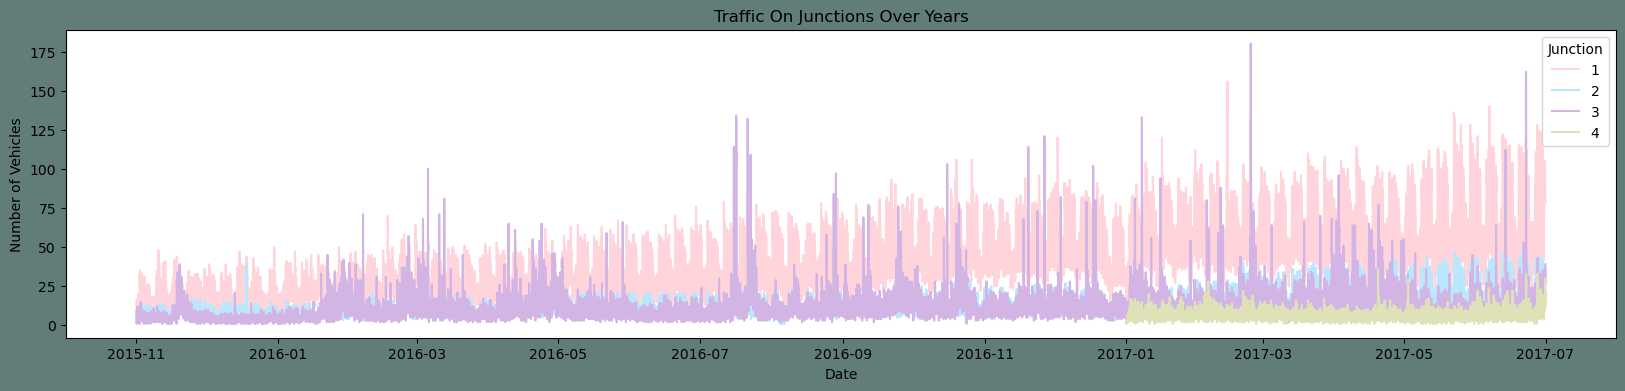

In [4]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [5]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


In [6]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

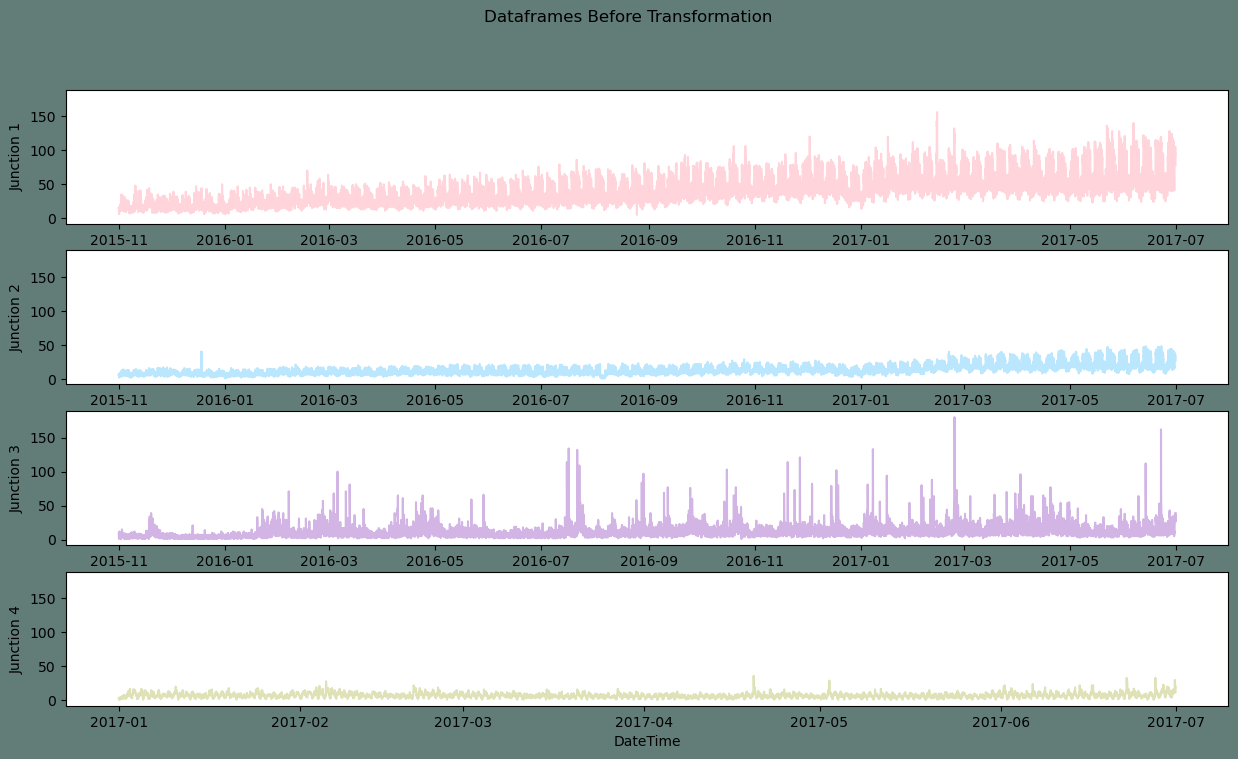

In [7]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")


In [8]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [9]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

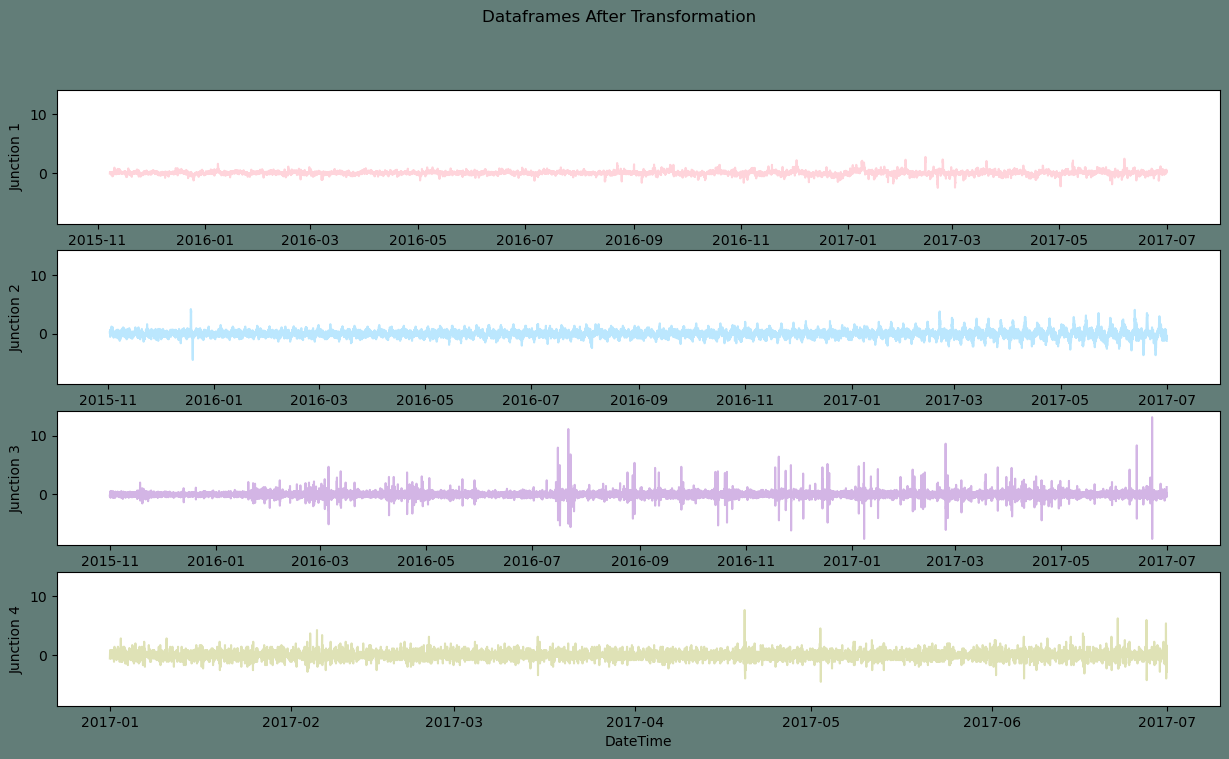

In [10]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [11]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415554
p-value: 4.798539876395033e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694002
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832707
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305282
p-value: 2.7787875325943866e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [12]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

#### Please  find the reference of the code above be clicking here 
https://www.kaggle.com/code/karnikakapoor/traffic-prediction-gru

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras import callbacks

# Model for the prediction
def CNN_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True) 
    # Callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    # The CNN model 
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    # Compiling the model
    model.compile(optimizer=SGD(momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, epochs=50, batch_size=150, callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN

# To calculate the root mean squared error in predictions
def RMSE_Value(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

# To plot the comparative plot of targets and predictions
def PredictionsPlot(test, predicted, m):
    plt.figure(figsize=(12, 5), facecolor="#627D78")
    plt.plot(test, color='blue', label="True Value", alpha=0.5)
    plt.plot(predicted, color='red', label="Predicted Values")
    plt.title("CNN Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [14]:
# Predictions For First Junction
PredJ1_CNN = CNN_model(X_trainJ1, y_trainJ1, X_testJ1)


Epoch 1/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0826
Epoch 2/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0743
Epoch 3/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0715
Epoch 4/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0696
Epoch 5/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0689
Epoch 6/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0671
Epoch 7/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0665
Epoch 8/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0660
Epoch 9/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0653
Epoch 10/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0648
Epoch 11/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0646
Epoch 12/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0643
Epoch 13/50
87/87 [==============================

87/87 [==============================] - 1s 6ms/step - loss: 0.0609
Epoch 33/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0610
Epoch 34/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0604
Epoch 35/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0606
Epoch 36/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0603
Epoch 37/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0602
Epoch 38/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0602
Epoch 39/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0604
Epoch 40/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0600
Epoch 41/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0603
Epoch 42/50
87/87 [==============================] - 1s 6ms/step - loss: 0.0599
Epoch 43/50
87/87 [==============================] - 1s 7ms/step - loss: 0.0596
Epoch 44/50
87/87 [==============================] -

The root mean squared error is 0.2895354923476754.


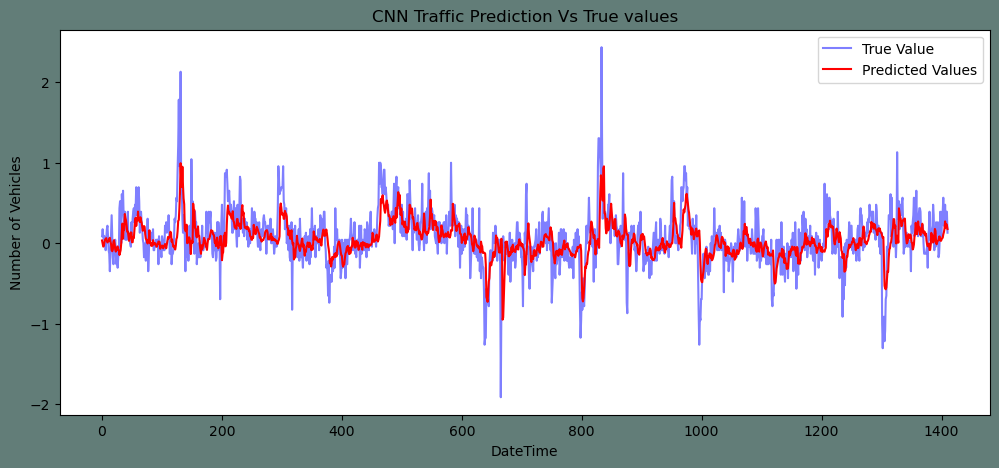

In [15]:
# Results for J1 
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 0)

In [16]:
# Predictions For Second Junction
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2)


Epoch 1/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2439
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2040
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1906
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1833
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1799
Epoch 6/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1752
Epoch 7/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1727
Epoch 8/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1698
Epoch 9/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1697
Epoch 10/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1658
Epoch 11/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1645
Epoch 12/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1647
Epoch 13/50
88/88 [==============================

88/88 [==============================] - 1s 6ms/step - loss: 0.1518
Epoch 33/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1488
Epoch 34/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1500
Epoch 35/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1508
Epoch 36/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1502
Epoch 37/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1484
Epoch 38/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1486
Epoch 39/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1501
Epoch 40/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1470
Epoch 41/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1473
Epoch 42/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1468
Epoch 43/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1483
Epoch 44/50
88/88 [==============================] -

The root mean squared error is 0.5695786215493366.


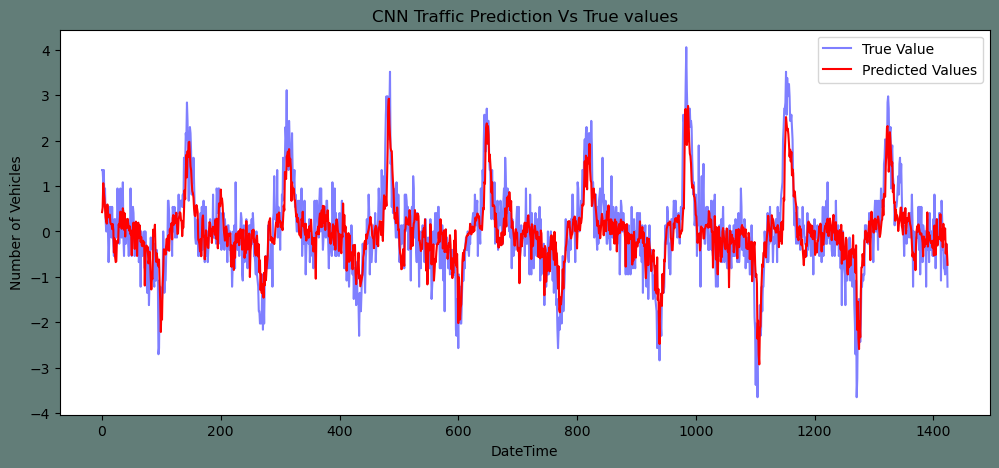

In [17]:
# Results for J2 
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 1)

In [18]:
# Predictions For Third Junction
PredJ3_CNN = CNN_model(X_trainJ3, y_trainJ3, X_testJ3)


Epoch 1/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2949
Epoch 2/50
88/88 [==============================] - 1s 7ms/step - loss: 0.2842
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2773
Epoch 4/50
88/88 [==============================] - 1s 7ms/step - loss: 0.2744
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2715
Epoch 6/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2688
Epoch 7/50
88/88 [==============================] - 1s 7ms/step - loss: 0.2681
Epoch 8/50
88/88 [==============================] - 1s 7ms/step - loss: 0.2679
Epoch 9/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2655
Epoch 10/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2659
Epoch 11/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2641
Epoch 12/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2640
Epoch 13/50
88/88 [==============================

88/88 [==============================] - 1s 6ms/step - loss: 0.2484
Epoch 33/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2493
Epoch 34/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2486
Epoch 35/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2481
Epoch 36/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2462
Epoch 37/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2451
Epoch 38/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2449
Epoch 39/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2457
Epoch 40/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2421
Epoch 41/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2419
Epoch 42/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2438
Epoch 43/50
88/88 [==============================] - 1s 6ms/step - loss: 0.2410
Epoch 44/50
88/88 [==============================] -

The root mean squared error is 0.6523866137611921.


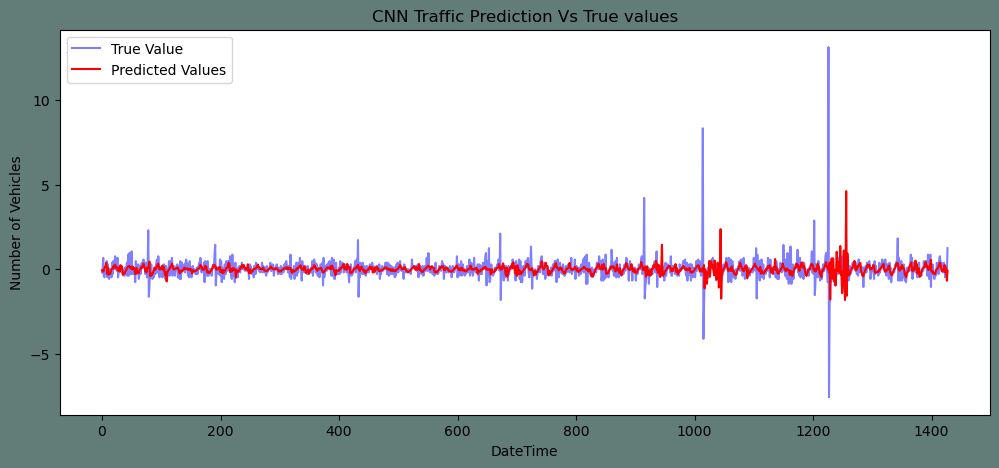

In [19]:
# Results for J3 
RMSE_J3_CNN = RMSE_Value(y_testJ3, PredJ3_CNN)
PredictionsPlot(y_testJ3, PredJ3_CNN, 2)

In [20]:
# Predictions For Fourth Junction
PredJ4_CNN = CNN_model(X_trainJ4, y_trainJ4, X_testJ4)


Epoch 1/50
26/26 [==============================] - 1s 6ms/step - loss: 0.6975
Epoch 2/50
26/26 [==============================] - 0s 6ms/step - loss: 0.6833
Epoch 3/50
26/26 [==============================] - 0s 6ms/step - loss: 0.6749
Epoch 4/50
26/26 [==============================] - 0s 6ms/step - loss: 0.6696
Epoch 5/50
26/26 [==============================] - 0s 6ms/step - loss: 0.6665
Epoch 6/50
26/26 [==============================] - 0s 6ms/step - loss: 0.6602
Epoch 7/50
26/26 [==============================] - 0s 6ms/step - loss: 0.6548
Epoch 8/50
26/26 [==============================] - 0s 6ms/step - loss: 0.6566
Epoch 9/50
26/26 [==============================] - 0s 6ms/step - loss: 0.6494
Epoch 10/50
26/26 [==============================] - 0s 7ms/step - loss: 0.6489
Epoch 11/50
26/26 [==============================] - 0s 7ms/step - loss: 0.6473
Epoch 12/50
26/26 [==============================] - 0s 7ms/step - loss: 0.6421
Epoch 13/50
26/26 [==============================

26/26 [==============================] - 0s 6ms/step - loss: 0.5771
Epoch 33/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5668
Epoch 34/50
26/26 [==============================] - 0s 7ms/step - loss: 0.5641
Epoch 35/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5658
Epoch 36/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5552
Epoch 37/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5517
Epoch 38/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5474
Epoch 39/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5384
Epoch 40/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5338
Epoch 41/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5379
Epoch 42/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5254
Epoch 43/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5163
Epoch 44/50
26/26 [==============================] -

The root mean squared error is 1.1979377718868407.


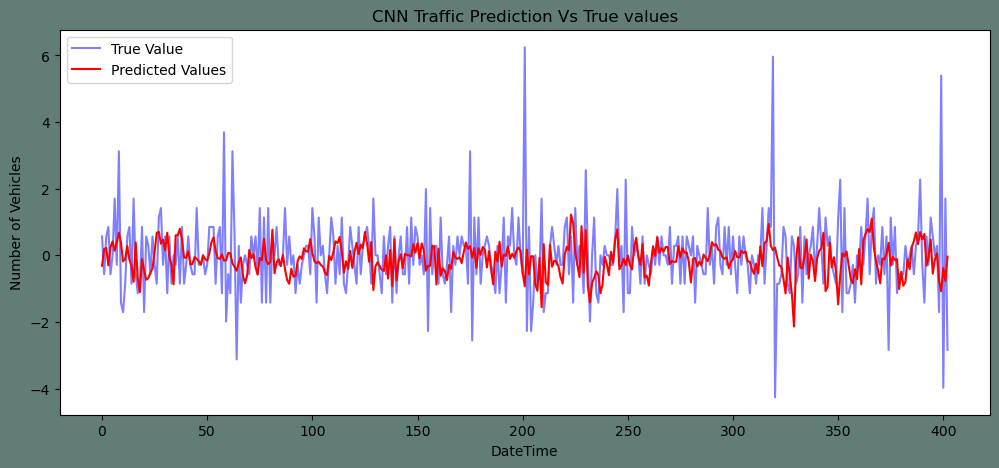

In [21]:
# Results for J4 
RMSE_J4_CNN = RMSE_Value(y_testJ4, PredJ4_CNN)
PredictionsPlot(y_testJ4, PredJ4_CNN, 3)